## Menguji Algoritma CNN untuk Translasi Wicara Ke Teks

# By : Thenardhi Syechlo

dataset:https://www.kaggle.com/datasets/basilb2s/language-detection?datasetId=1150837&sortBy=dateRun&tab=profile

we'll build Model to use it speech recognition for thirty words

dataset consisting of 41849 audio

# Importing Libraries & Data

In [1]:
import librosa as lr
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import IPython.display as ipd
import keras
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pickle as pk
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
dataset='speech-using-cnn-96/augmented_dataset/augmented_dataset'
pd.DataFrame(os.listdir(dataset),columns=['Files'])

,Files
0,bed
1,bird
2,cat
3,dog
4,down
5,eight
6,five
7,four
8,go
9,happy


In [3]:
def count(path):
    size=[]
    for file in os.listdir(path):
        size.append(len(os.listdir(os.path.join(path,file))))
    return pd.DataFrame(size,columns=['Number Of Sample'],index=os.listdir(path))  
tr=count(dataset)
tr

,Number Of Sample
bed,1356
bird,1346
cat,1378
dog,1474
down,1188
eight,1113
five,1092
four,2400
go,960
happy,1481


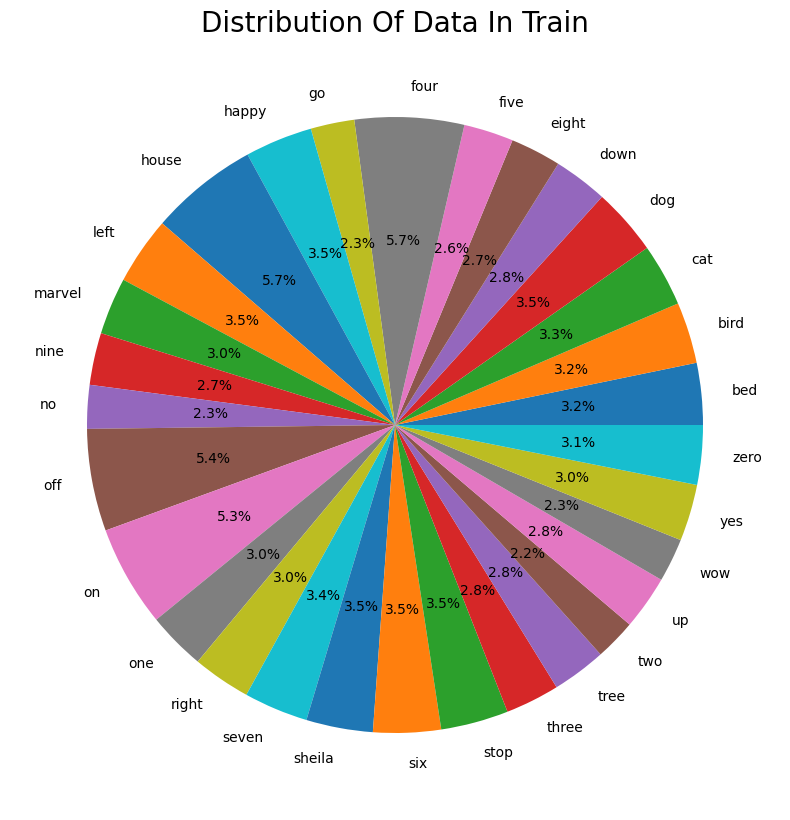

In [4]:
plt.figure(figsize=(10,10))
plt.pie(x='Number Of Sample',labels=os.listdir(dataset),autopct ='%1.1f%%',data=tr)
plt.title('Distribution Of Data In Train',fontsize=20)
plt.show()

Text(0, 0.5, 'Count')

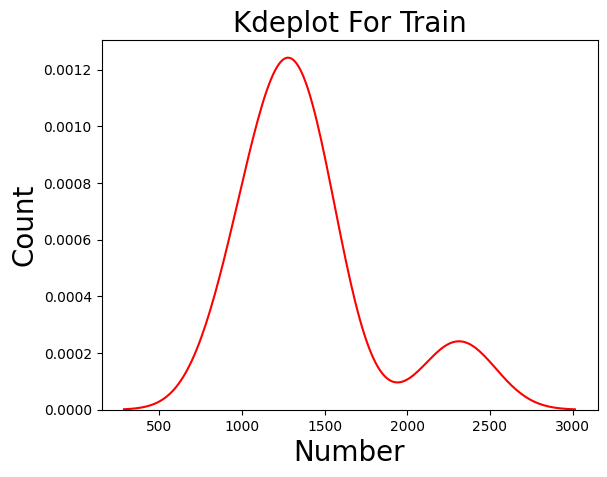

In [5]:
sns.kdeplot(tr['Number Of Sample'], color='red')
plt.title('Kdeplot For Train', fontsize=20)
plt.xlabel('Number', fontsize=20)
plt.ylabel('Count', fontsize=20)

In [6]:
#bed Audio
ipd.Audio('speech-using-cnn-96/augmented_dataset/augmented_dataset/bed/1014.wav')

In [7]:
#bird Audio
ipd.Audio('speech-using-cnn-96/augmented_dataset/augmented_dataset/bird/1019.wav')

In [8]:
#cat Audio
ipd.Audio('speech-using-cnn-96/augmented_dataset/augmented_dataset/cat/1009.wav')

In [9]:
#yes Audio
ipd.Audio('speech-using-cnn-96/augmented_dataset/augmented_dataset/yes/1014.wav')

In [10]:
def load(path):
    data=[]
    label=[]
    sample=[]
    for file in os.listdir(path):
        path_=os.path.join(path,file)
        for fil in os.listdir(path_):
            data_contain,sample_rate=lr.load(os.path.join(path_,fil) ,sr=16000)
            data.append(data_contain)
            sample.append(sample_rate)
            label.append(file)
    return data,label,sample

In [11]:
data,label,sample=load(dataset)
df=pd.DataFrame()
df['Label'],df['sample']=label,sample
df

,Label,sample
0,bed,16000
1,bed,16000
2,bed,16000
3,bed,16000
4,bed,16000
...,...,...
41844,zero,16000
41845,zero,16000
41846,zero,16000
41847,zero,16000


# Audio Feature Extraction

In [12]:
#waveform
def waveform(data,sr,label):
    plt.figure(figsize=(14, 5))
    lr.display.waveshow(data, sr=sr)
    plt.suptitle(label)
    plt.title('Waveform plot')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
#MFCC features
def mfcc(data, sr):
    mfccs = lr.feature.mfcc(y=data, sr=sr)
    return np.mean(mfccs), mfccs
def mfcc_v(mfccs,label):
    plt.figure(figsize=(10, 4))
    lr.display.specshow(mfccs, x_axis='time')
    plt.colorbar()
    plt.title('MFCC')
    plt.suptitle(label)
#Mel-spectrogram
def Mel(data, sr):
    mel_spec = lr.feature.melspectrogram(y=data, sr=sr)
    return np.mean(mel_spec), mel_spec
def mel_v(mel_spec,label,sr):
    # Convert to decibel scale
    mel_spec_db = lr.power_to_db(mel_spec, ref=np.max)
    # Visualize Mel-spectrogram
    plt.figure(figsize=(10, 4))
    lr.display.specshow(mel_spec_db, x_axis='time', y_axis='mel', sr=sr)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-spectrogram')
    plt.suptitle(label)
#zero_crossing_rate
def zero_crossing(data,sr):
    # Compute zero-crossing rate
    zcr = lr.feature.zero_crossing_rate(data)
    # Print average zero-crossing rate
    avg_zcr = sum(zcr[0])/len(zcr[0])
    print("Average zero-crossing rate:", avg_zcr)
    return zcr
def zero_crossing_v(zcr,label,data,sr):
    time = lr.times_like(zcr)
    # Create waveform plot
    plt.figure(figsize=(14, 5))
    lr.display.waveshow(data, sr=sr, alpha=0.5)
    plt.plot(time, zcr[0], color='r')
    plt.title('Zero-crossing rate')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.suptitle(label)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


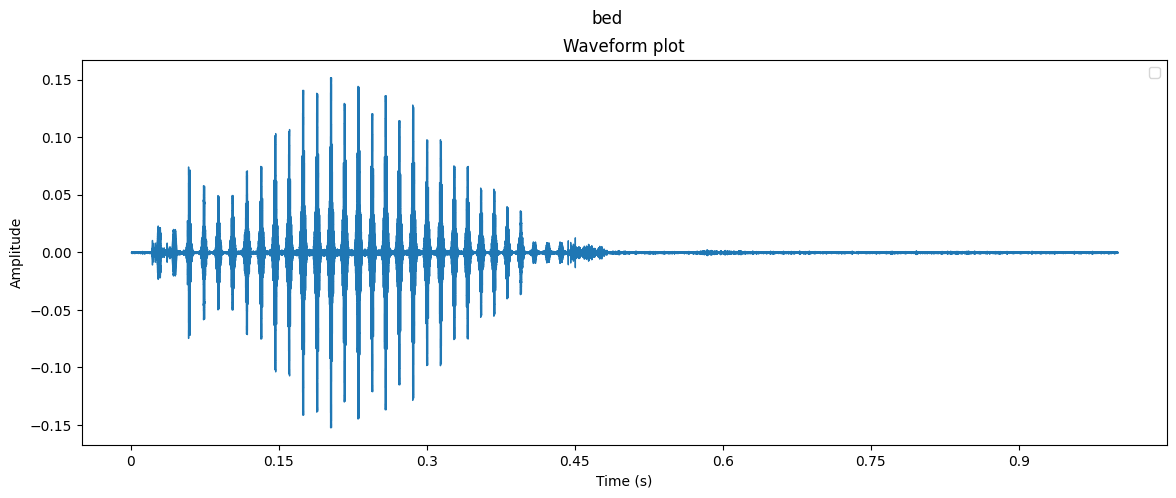

In [13]:
#waveform data[0]
waveform(data[0],sample[0],label[0])
plt.legend()

MFCCs Mean: -22.473103
MFCCs shape: (20, 32)


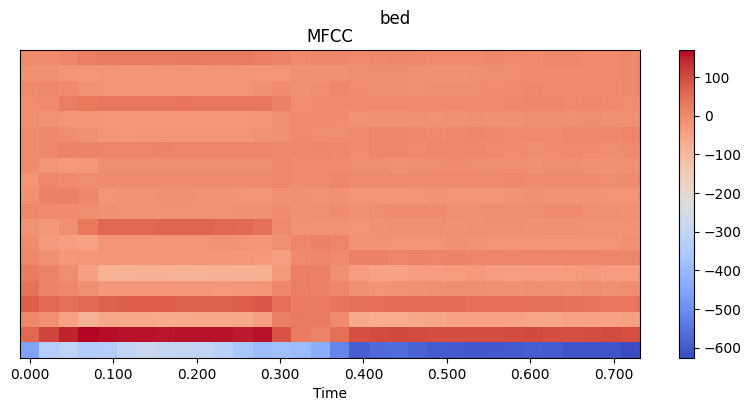

In [14]:
#MFCC data[0]
mfccs_mean, mfccs = mfcc(data[0], sample[0])
print('MFCCs Mean:', mfccs_mean)
print('MFCCs shape:', mfccs.shape)
mfcc_v(mfccs,label[0])

Mel Mean: 0.04585984
Mel : (128, 32)


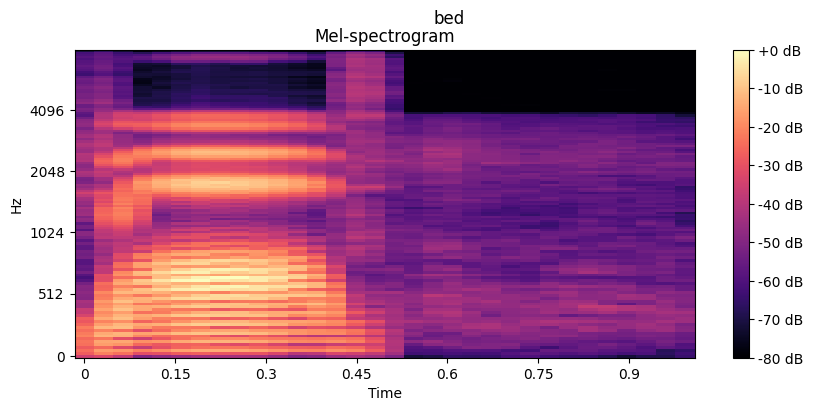

In [15]:
##Mel-spectrogram data[0]
mel_mean,mel=Mel(data[0],sample[0])
print('Mel Mean:',mel_mean)
print('Mel :',mel.shape)
mel_v(mel,label[0],sample[0])

Average zero-crossing rate: 0.1768035888671875
Zcr: (1, 32)


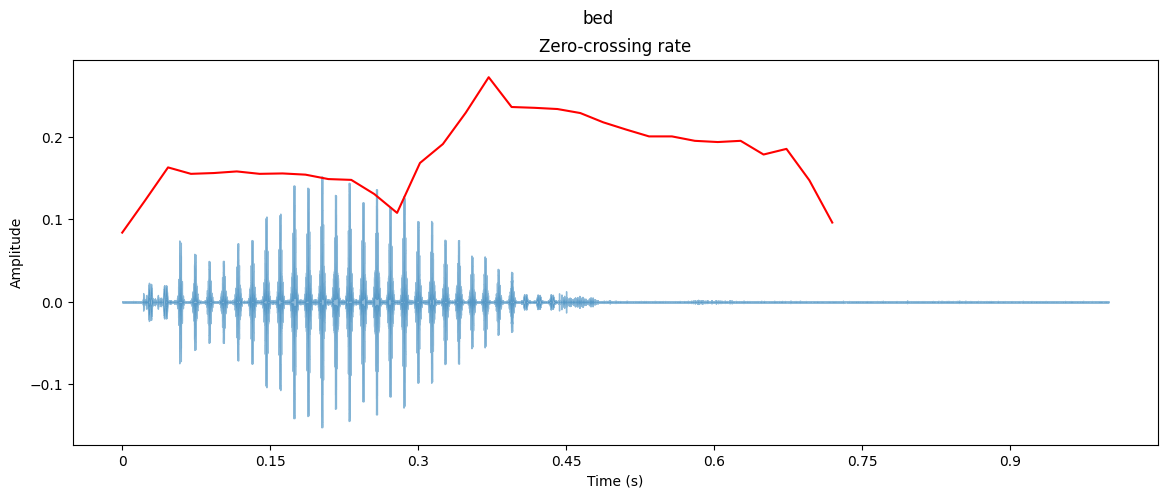

In [16]:
#zero_crossing data[0]
zcr=zero_crossing(data[0],sample[0])
print('Zcr:',zcr.shape)
zero_crossing_v(zcr,label[0],data[0],sample[0])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


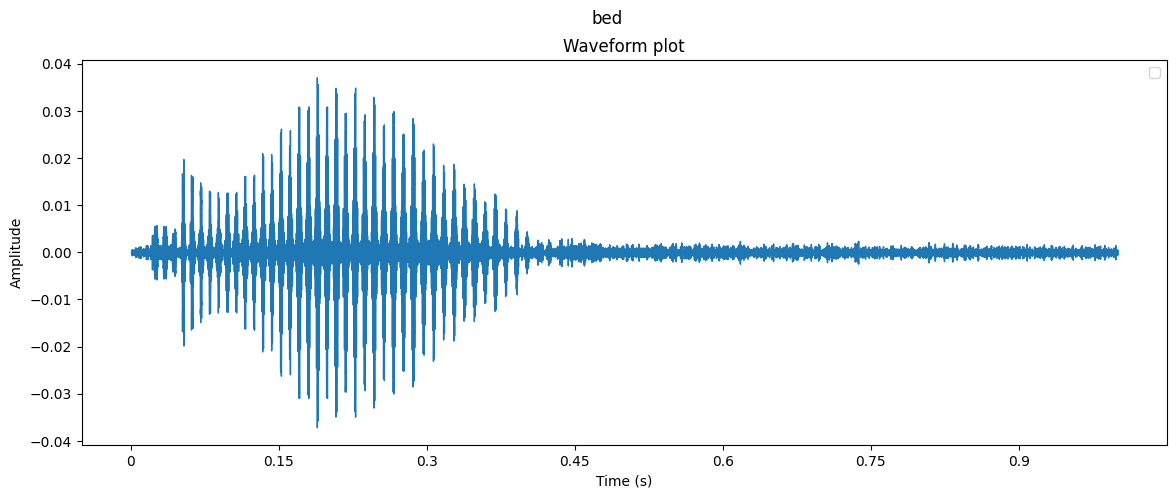

In [17]:
#waveform data[1000]
waveform(data[1000],sample[1000],label[1000])
plt.legend()

MFCCs Mean: -20.893103
MFCCs shape: (20, 32)


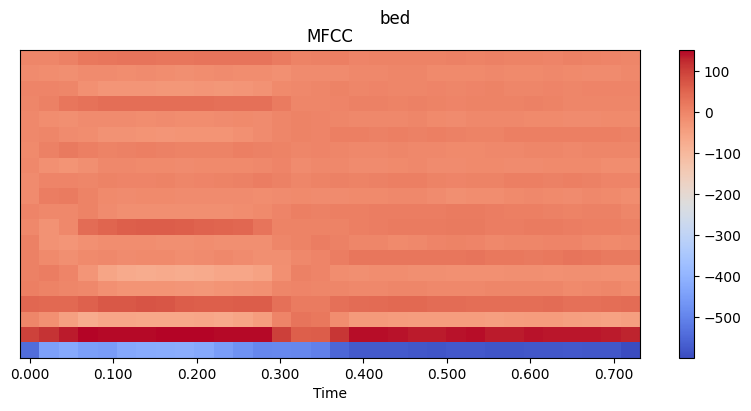

In [18]:
#MFCC data[1000]
mfccs_mean, mfccs = mfcc(data[1000], sample[1000])
print('MFCCs Mean:', mfccs_mean)
print('MFCCs shape:', mfccs.shape)
mfcc_v(mfccs,label[1000])

Mel Mean: 0.0037993134
Mel : (128, 32)


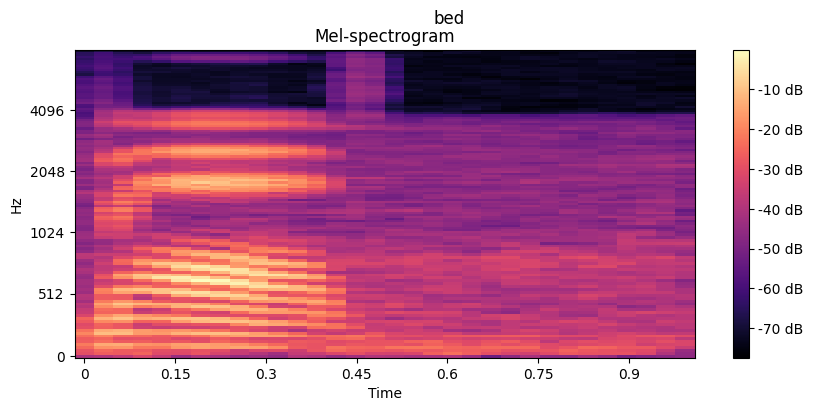

In [19]:
##Mel-spectrogram data[1000]
mel_mean,mel=Mel(data[1000],sample[1000])
print('Mel Mean:',mel_mean)
print('Mel :',mel.shape)
mel_v(mel,label[1000],sample[1000])

Average zero-crossing rate: 0.1236572265625
Zcr: (1, 32)


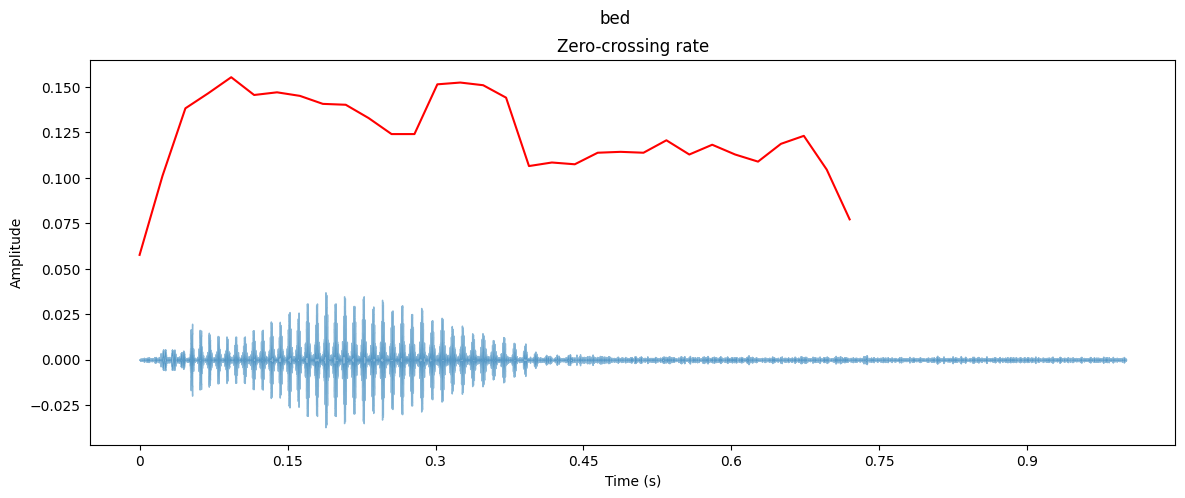

In [20]:
#zero_crossing data[1000]
zcr=zero_crossing(data[1000],sample[1000])
print('Zcr:',zcr.shape)
zero_crossing_v(zcr,label[1000],data[1000],sample[1000])

In [21]:
code={}
x=0
for i in pd.unique(label):
    code[i]=x
    x+=1
pd.DataFrame(code.values(),columns=['Value'],index=code.keys())   

,Value
bed,0
bird,1
cat,2
dog,3
down,4
eight,5
five,6
four,7
go,8
happy,9


In [22]:
def get_Name(N):
    for x,y in code.items():
          if y==N:
                return x
for i in range(len(label)):
    label[i]=code[label[i]]
pd.DataFrame(label,columns=['Labels'])    

,Labels
0,0
1,0
2,0
3,0
4,0
...,...
41844,29
41845,29
41846,29
41847,29


# Splitting Data

In [23]:
data=np.array(data).reshape(-1,16000,1)
label=np.array(label)
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.25, random_state=44, shuffle =True)
print('X_train shape is ' , X_train.shape)
print('X_test shape is ' , X_test.shape)
print('y_train shape is ' , y_train.shape)
print('y_test shape is ' , y_test.shape)

X_train shape is  (31386, 16000, 1)
X_test shape is  (10463, 16000, 1)
y_train shape is  (31386,)
y_test shape is  (10463,)


# Model Building 

In [24]:
num_class=len(pd.unique(label))
model=keras.Sequential()
model.add(keras.layers.Conv1D(filters=8, kernel_size=13,activation=tf.nn.relu,input_shape=(16000,1)))
model.add(keras.layers.MaxPooling1D(3))
model.add(keras.layers.Dropout(.3))
model.add(keras.layers.Conv1D(filters=16, kernel_size=11,activation=tf.nn.relu))
model.add(keras.layers.MaxPooling1D(3))
model.add(keras.layers.Dropout(.3))
model.add(keras.layers.Conv1D(filters=32, kernel_size=9,activation=tf.nn.relu))
model.add(keras.layers.MaxPooling1D(3))
model.add(keras.layers.Dropout(.3))
model.add(keras.layers.Conv1D(filters=64, kernel_size=7,activation=tf.nn.relu))
model.add(keras.layers.MaxPooling1D(3))
model.add(keras.layers.Dropout(.3))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256,activation=tf.nn.relu))
model.add(keras.layers.Dropout(.3))
model.add(keras.layers.Dense(128,activation=tf.nn.relu))
model.add(keras.layers.Dropout(.3))
model.add(keras.layers.Dense(num_class,activation=tf.nn.softmax))

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 15988, 8)          112       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 5329, 8)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 5329, 8)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 5319, 16)          1424      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1773, 16)         0         
 1D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 1773, 16)          0

In [26]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [27]:
model.compile(optimizer ='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
hist=model.fit(X_train,y_train,epochs=30)

Epoch 1/30
981/981 [==============================] - 148s 149ms/step - loss: 2.5062 - accuracy: 0.2407
Epoch 2/30
981/981 [==============================] - 135s 138ms/step - loss: 1.3895 - accuracy: 0.5500
Epoch 3/30
981/981 [==============================] - 134s 137ms/step - loss: 0.8470 - accuracy: 0.7211
Epoch 4/30
981/981 [==============================] - 134s 137ms/step - loss: 0.6359 - accuracy: 0.7914
Epoch 5/30
981/981 [==============================] - 135s 137ms/step - loss: 0.5142 - accuracy: 0.8308
Epoch 6/30
981/981 [==============================] - 134s 137ms/step - loss: 0.4327 - accuracy: 0.8569
Epoch 7/30
981/981 [==============================] - 134s 137ms/step - loss: 0.3701 - accuracy: 0.8774
Epoch 8/30
981/981 [==============================] - 135s 137ms/step - loss: 0.3403 - accuracy: 0.8892
Epoch 9/30
981/981 [==============================] - 135s 137ms/step - loss: 0.3118 - accuracy: 0.8968
Epoch 10/30
981/981 [==============================] - 135s 138m

In [28]:
loss,acc=model.evaluate(X_test,y_test)
print('Loss is :',loss)
print('ACC is :',acc)

327/327 [==============================] - 7s 22ms/step - loss: 0.0991 - accuracy: 0.9724
Loss is : 0.09909921884536743
ACC is : 0.9723788499832153


In [29]:
hist_=hist.history
pd.DataFrame(hist_)

,loss,accuracy
0,2.506236,0.240681
1,1.389497,0.549959
2,0.847005,0.721118
3,0.635947,0.791372
4,0.514193,0.830753
5,0.432736,0.856943
6,0.370115,0.877366
7,0.340263,0.889154
8,0.311841,0.896769
9,0.289167,0.903747


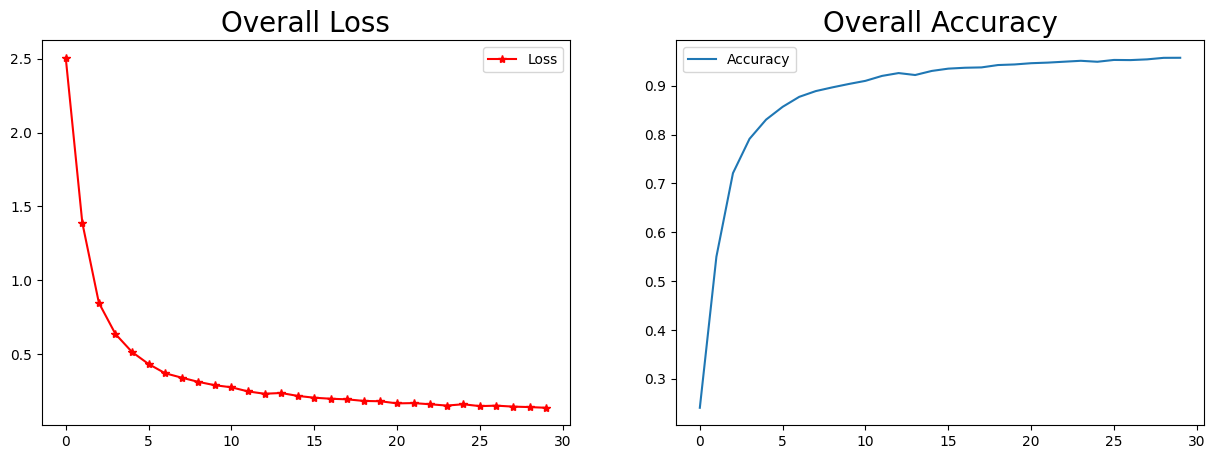

In [30]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],c='r',marker='*',label='Loss')
plt.title('Overall Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Accuracy')
plt.title('Overall Accuracy',fontsize=20)
plt.legend()

In [31]:
# Simpan akurasi ke dalam sebuah file teks
with open('akurasi2.txt', 'w') as file:
    file.write(str(acc))

In [32]:
predict=model.predict(X_test)
predict[0]

327/327 [==============================] - 7s 22ms/step


array([6.0018648e-19, 7.9495457e-18, 1.8811685e-15, 2.8007491e-10,
       2.1612474e-18, 3.3866225e-23, 4.3662526e-12, 1.0000000e+00,
       5.7048866e-12, 1.1465756e-30, 5.3112086e-14, 2.0002063e-27,
       6.0434688e-20, 3.1410199e-28, 1.1906641e-22, 1.1111336e-08,
       8.2672093e-15, 2.9107204e-24, 5.0715965e-18, 9.8667579e-26,
       7.6552288e-15, 4.1612078e-35, 9.1909075e-10, 2.1458731e-29,
       1.3720337e-33, 4.5797974e-10, 5.4529370e-10, 1.0951301e-16,
       1.1096422e-31, 2.7794085e-18], dtype=float32)

In [33]:
preN=[]
prename=[]
for row in predict:
    N=np.argmax(row)
    preN.append(N)
    prename.append(get_Name(N))
pd.DataFrame(prename,columns=['Predictions'])

,Predictions
0,four
1,stop
2,left
3,off
4,up
...,...
10458,house
10459,up
10460,four
10461,off


In [34]:
predict=[]
y_act=[]
for p in range(30):
    y_act.append(get_Name(y_test[p]))
    predict.append(prename[p])
pd_p=pd.DataFrame(y_act,columns=['y_act'])  
pd_p['predict']=predict
pd_p

,y_act,predict
0,four,four
1,stop,stop
2,left,left
3,wow,off
4,up,up
5,nine,nine
6,sheila,sheila
7,house,house
8,one,one
9,no,no


# Model Check

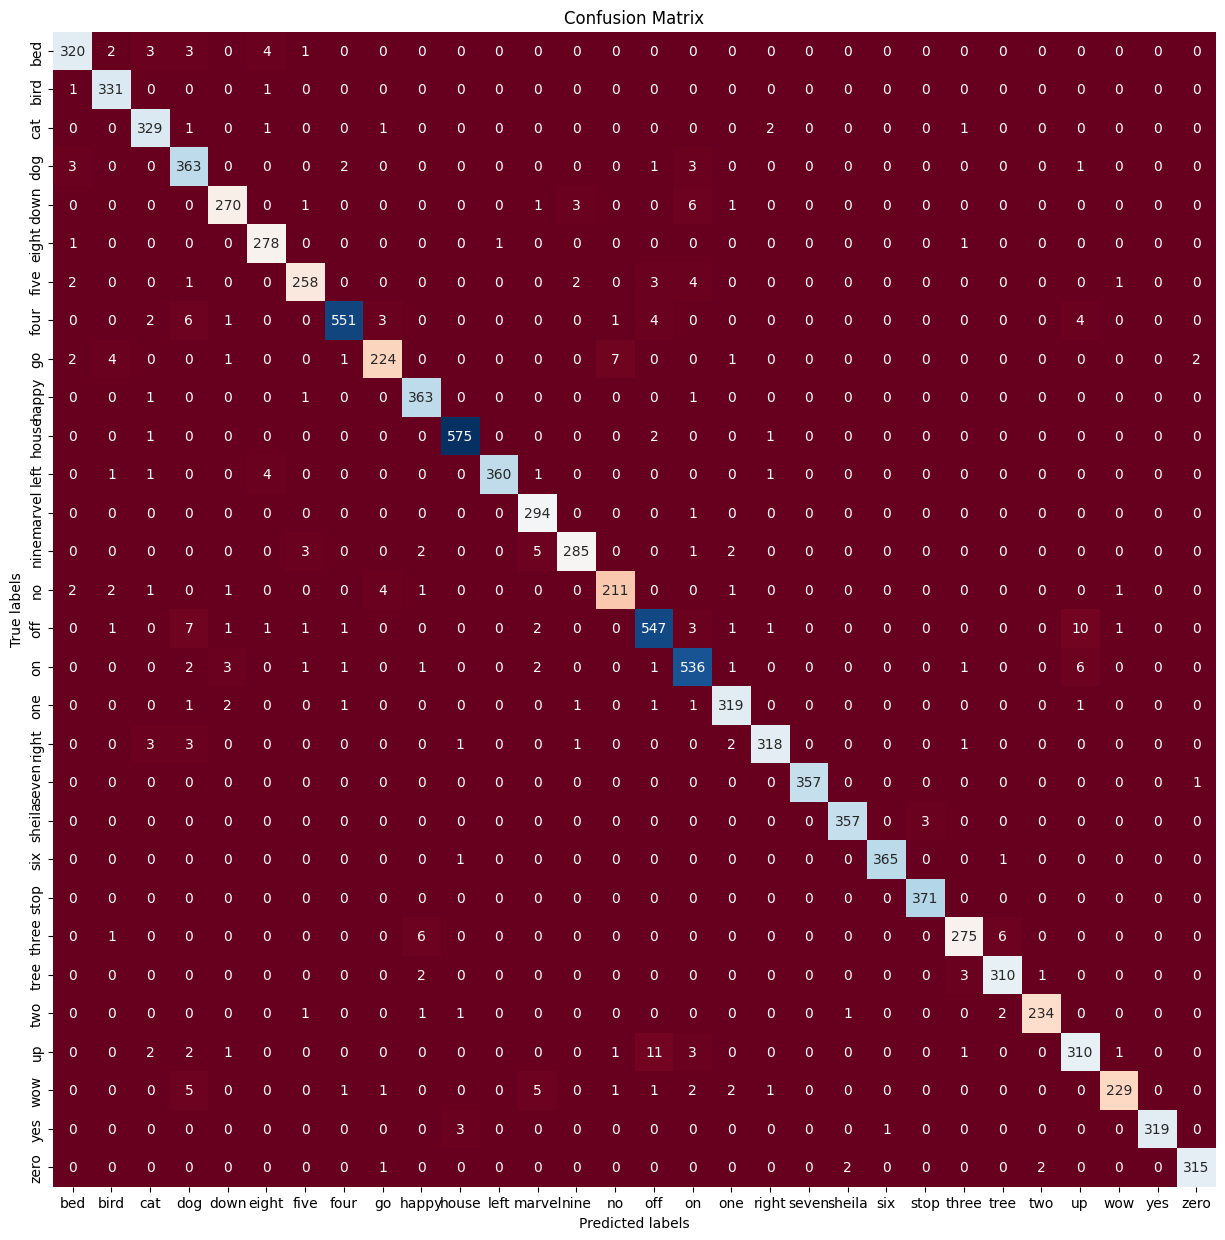

array([[320,   2,   3,   3,   0,   4,   1,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0],
       [  1, 331,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0],
       [  0,   0, 329,   1,   0,   1,   0,   0,   1,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   2,   0,   0,   0,   0,   1,   0,   0,
          0,   0,   0,   0],
       [  3,   0,   0, 363,   0,   0,   0,   2,   0,   0,   0,   0,   0,
          0,   0,   1,   3,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          1,   0,   0,   0],
       [  0,   0,   0,   0, 270,   0,   1,   0,   0,   0,   0,   0,   1,
          3,   0,   0,   6,   1,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0],
       [  1,   0,   0,   0,   0, 278,   0,   0,   0,   0,   0,   1,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,

In [35]:
plt.figure(figsize=(15,15))
ax= plt.subplot()
CM = confusion_matrix(y_test, preN)
sns.heatmap(CM, annot=True, fmt='g', ax=ax,cbar=False,cmap='RdBu')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(code.keys()) 
ax.yaxis.set_ticklabels(code.keys())
plt.show()
CM

In [36]:
ClassificationReport = classification_report(y_test,preN)
print('Classification Report is : ', ClassificationReport )

Classification Report is :                precision    recall  f1-score   support

           0       0.97      0.96      0.96       333
           1       0.97      0.99      0.98       333
           2       0.96      0.98      0.97       335
           3       0.92      0.97      0.95       373
           4       0.96      0.96      0.96       282
           5       0.96      0.99      0.98       281
           6       0.97      0.95      0.96       271
           7       0.99      0.96      0.98       572
           8       0.96      0.93      0.94       242
           9       0.97      0.99      0.98       366
          10       0.99      0.99      0.99       579
          11       1.00      0.98      0.99       368
          12       0.95      1.00      0.97       295
          13       0.98      0.96      0.97       298
          14       0.95      0.94      0.95       224
          15       0.96      0.95      0.95       577
          16       0.96      0.97      0.96       555

# Save Model

In [37]:
model.save('pretrain.h5')

In [38]:
savedmodel=keras.models.load_model('pretrain.h5')

# GOOD LUCK🤞🤞
Prof.Dr.𝔄𝔥𝔪𝔢𝔡 𝔄𝔰𝔥𝔯𝔞𝔣